In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import Model,optimizers,losses
from tensorflow.keras.layers import *

%matplotlib inline

In [2]:
X = np.load( "face_landmarks_cleaned/x_train.npy" ).reshape(-1,96,96) / 255 
Y = np.load( "face_landmarks_cleaned/y_train.npy" ).astype(np.float32) / 96
x = np.load( "face_landmarks_cleaned/x_test.npy" ).reshape(-1,96,96) / 255
y = np.load( "face_landmarks_cleaned/y_test.npy" ).astype(np.float32) / 96

for i in range(len(X)):X[i] = X[i].T
for i in range(len(x)):x[i] = x[i].T
    
X = X.reshape(-1,96,96,1)
x = x.reshape(-1,96,96,1)

In [3]:
Y[0]

array([0.7004176 , 0.37987363, 0.30753297, 0.36023077, 0.6316648 ,
       0.39215386, 0.7814505 , 0.3946099 , 0.3811978 , 0.38232967,
       0.23632418, 0.37741756, 0.6169286 , 0.29884067, 0.84038466,
       0.3283077 , 0.41557693, 0.29392856, 0.17002197, 0.30375275,
       0.501522  , 0.5370275 , 0.64885163, 0.76785165, 0.309989  ,
       0.7555714 , 0.49415386, 0.69172525, 0.48678574, 0.8464286 ],
      dtype=float32)

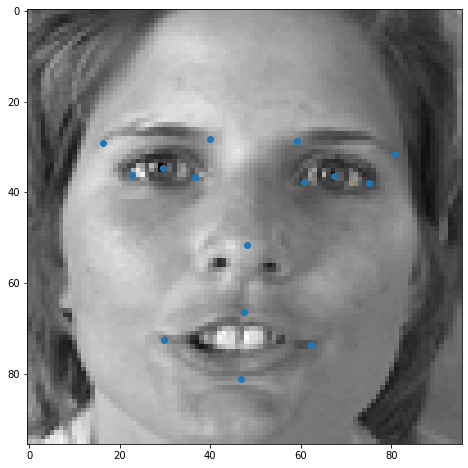

In [4]:
plt.figure(figsize=(8,8))
plt.imshow(X[0,:,:,0],cmap='gray')
plt.scatter(Y[0,::2]*96,Y[0,1::2]*96)

In [5]:
def conv(x,filters,kernel_size=1,strides=1,use_bias=True):
    x = Conv2D(filters,kernel_size=kernel_size,strides=strides,use_bias=use_bias,padding='same')(x)
    return x

def conv_bt(x,filters,kernel_size=1,strides=1,use_bias=True):
    x = Conv2D(filters,kernel_size=kernel_size,strides=strides,use_bias=use_bias,padding='same')(x)
    x = BatchNormalization()(x)
    return x

def conv_bt_act(x,filters,kernel_size=1,strides=1,use_bias=True,activation='swish',padding='same'):
    x = Conv2D(filters,kernel_size=kernel_size,strides=strides,use_bias=use_bias,padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    return x

def dwconv(x,kernel_size=3,strides=1,use_bias=True):
    x = DepthwiseConv2D(kernel_size=kernel_size,strides=strides,use_bias=use_bias,padding='same')(x)
    return x

def dwconv_bt(x,kernel_size=3,strides=1,use_bias=True):
    x = DepthwiseConv2D(kernel_size=kernel_size,strides=strides,use_bias=use_bias,padding='same')(x)
    x = BatchNormalization()(x)
    return x

def dwconv_bt_act(x,kernel_size=3,strides=1,use_bias=True,activation='swish'):
    x = DepthwiseConv2D(kernel_size=kernel_size,strides=strides,use_bias=use_bias,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    return x

def block(x,filters,strides=1):
    x = dwconv_bt_act(x)
    x = conv_bt_act(x,filters,strides=strides)
    return x


# out = GlobalAveragePooling2D()(b4)
# out = Dense(30,use_bias=False)(out)
# out = BatchNormalization()(out)
# out = Activation("sigmoid")(out)

im_in = Input(shape=(96,96,1))

b1 = conv_bt_act(im_in,16,kernel_size=3,strides=2)

b2 = block(b1,32,2)
b2 = Dropout(0.25)(b2)

b3 = block(b2,64)
b3 = block(b3,64,2)
b3 = Dropout(0.25)(b3)

b4 = block(b3,128)
b4 = block(b4,128)
b4 = block(b4,128,2)
b4 = Dropout(0.25)(b4)

dy = tf.math.reduce_mean(b4,axis=1)
dy = Conv1D(15,1,padding='same')(dy)
dy = BatchNormalization()(dy)
dy = Activation('sigmoid')(dy)
dy = GlobalAvgPool1D()(dy)
dy = Reshape((15,1))(dy)

dx = tf.math.reduce_mean(b4,axis=2)
dx = Conv1D(15,1,padding='same')(dx)
dx = BatchNormalization()(dx)
dx = Activation('sigmoid')(dx)
dx = GlobalAvgPool1D()(dx)
dx = Reshape((15,1))(dx)

out = Concatenate(axis=-1)([dx,dy])
out = Reshape((30,))(out)


model = Model(im_in,out)
# tf.image.rot90

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
opt = optimizers.Adam(learning_rate=0.00009)
loss = losses.MeanAbsoluteError()

model.compile(loss=loss,optimizer=opt,metrics=['mae'])

In [8]:
X.shape,Y.shape

((1498, 96, 96, 1), (1498, 30))

In [9]:
model.fit(x=X,y=Y,batch_size=32,epochs=100,validation_data=(x,y))

Epoch 1/100
47/47 [==============================] - 34s 40ms/step - loss: 0.1807 - mae: 0.1807 - val_loss: 0.1678 - val_mae: 0.1678
Epoch 2/100
47/47 [==============================] - 1s 22ms/step - loss: 0.1690 - mae: 0.1690 - val_loss: 0.1573 - val_mae: 0.1573
Epoch 3/100
47/47 [==============================] - 1s 22ms/step - loss: 0.1619 - mae: 0.1619 - val_loss: 0.1436 - val_mae: 0.1436
Epoch 4/100
47/47 [==============================] - 1s 21ms/step - loss: 0.1567 - mae: 0.1567 - val_loss: 0.1281 - val_mae: 0.1281
Epoch 5/100
47/47 [==============================] - 1s 22ms/step - loss: 0.1527 - mae: 0.1527 - val_loss: 0.1142 - val_mae: 0.1142
Epoch 6/100
47/47 [==============================] - 1s 22ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.1035 - val_mae: 0.1035
Epoch 7/100
47/47 [==============================] - 1s 21ms/step - loss: 0.1463 - mae: 0.1463 - val_loss: 0.0957 - val_mae: 0.0957
Epoch 8/100
47/47 [==============================] - 1s 21ms/step - loss: 0

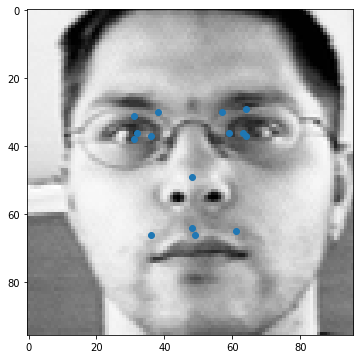

In [10]:
i = np.random.randint(0,len(x))
pred = (96 * model.predict(x[i:i+1])).astype(int)[0,:]

plt.figure(figsize=(6,6))
plt.imshow(x[i,:,:,0],cmap='gray')
plt.scatter(pred[::2],pred[1::2])

In [11]:
pred,(Y[i,:]*96).astype(int)

(array([63, 36, 32, 36, 59, 36, 64, 37, 36, 37, 31, 38, 57, 30, 64, 29, 38,
        30, 31, 31, 48, 49, 61, 65, 36, 66, 48, 64, 49, 66]),
 array([67, 37, 31, 37, 62, 38, 74, 39, 36, 37, 25, 38, 59, 26, 82, 30, 42,
        27, 20, 27, 48, 60, 62, 71, 34, 70, 49, 66, 48, 80]))

In [232]:
with open("./model/model.json","w+") as json:
    json.write(model.to_json())
    
model.save_weights("./model/weights")

In [234]:
!zip 

Copyright (c) 1990-2008 Info-ZIP - Type 'zip "-L"' for software license.
Zip 3.0 (July 5th 2008). Usage:
zip [-options] [-b path] [-t mmddyyyy] [-n suffixes] [zipfile list] [-xi list]
  The default action is to add or replace zipfile entries from list, which
  can include the special name - to compress standard input.
  If zipfile and list are omitted, zip compresses stdin to stdout.
  -f   freshen: only changed files  -u   update: only changed or new files
  -d   delete entries in zipfile    -m   move into zipfile (delete OS files)
  -r   recurse into directories     -j   junk (don't record) directory names
  -0   store only                   -l   convert LF to CR LF (-ll CR LF to LF)
  -1   compress faster              -9   compress better
  -q   quiet operation              -v   verbose operation/print version info
  -c   add one-line comments        -z   add zipfile comment
  -@   read names from stdin        -o   make zipfile as old as latest entry
  -x   exclude the following nam